# This notebook

In this notebook, we exlore the co-occurrence of keywords across the news articles to detect patterns of co-occurrence: which keywords tend to be discussed in the same context? 

## Settings

In [1]:
import os

In [2]:
import numpy as np

In [3]:
from math import log2

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import networkx as nx

In [6]:
%matplotlib inline

In [7]:
from src.news_media.get_keywords_trend import *

/Users/alessiatosi/DS_projects/behavioural-sci-perception/docs/ext/keywords.yaml has been successfully loaded as a dict


The config file

In [8]:
CONFIG.keys()

dict_keys(['NgramRange', 'Actors', 'BehavSci', 'Nudge', 'Positive', 'Negative', 'Covid', 'Fatigue', 'Immunity', 'SingularPlural'])

## Import UK's news articles

In [9]:
news_uk = NewsArticles(country="uk")

`news_uk` is a `NewsArticles` class instance, with the following public attributes and methods:

In [10]:
[d for d in dir(news_uk) if not d.startswith("_")]

['country',
 'data',
 'dates',
 'expand_dict',
 'get_num_ngrams',
 'kword_docfreq',
 'kword_normlen_tf',
 'kword_normlog_tf',
 'kword_raw_tf',
 'kword_yn_occurrence',
 'theme_docfreq',
 'theme_normlen_f',
 'theme_normlog_f',
 'theme_rawfreq',
 'unigram_count_perdoc']

`news_uk.data` contains the original dataset of articles:

In [11]:
news_uk.data.shape

(599, 13)

# Binary frequency of keyword occurrence

## Calculate yes/no occurrence of keyword per article

Here we capture whether a keyword is mentioned in an article or not, regardless of how many times if so (in the same article).

In [12]:
news_uk.kword_yn_occurrence

thaler  sunstein  kahneman  halpern  michie  chater  spi-b  \
id  pub_date                                                                 
0   2020-01-23       0         0         0        0       0       0      0   
1   2020-01-23       0         0         0        0       0       0      0   
2   2020-01-23       0         0         0        0       0       0      0   
3   2020-01-23       0         0         0        0       0       0      0   
4   2020-01-26       0         0         0        0       0       0      0   
...                ...       ...       ...      ...     ...     ...    ...   
594 2020-05-10       0         0         0        0       0       0      0   
595 2020-05-10       0         0         0        0       0       0      1   
596 2020-05-10       0         0         0        0       1       0      0   
597 2020-05-10       0         0         0        0       1       0      0   
598 2020-05-10       0         0         0        0       1       0      0   

                nudge_unit  behavioural_insights_team  behavioural_science  \
id  pub_date                                                                 
0   2020-01-23           0                          0                    0   
1   2020-01-23           0                          0                    0   
2   2020-01-23           0                          0                    1   
3   2020-01-23           0                          0                    0   
4   2020-01-26           1                          1                    0   
...                    ...                        ...                  ...   
594 2020-05-10           0                          0                    0   
595 2020-05-10           0                          0                    0   
596 2020-05-10           0                          0                    0   
597 2020-05-10           0                          0                    0   
598 2020-05-10           0                          0                    0   

                ...  paternalism  nanny_state  voodoo_science  police_state  \
id  pub_date    ...                                                           
0   2020-01-23  ...            0            0               0             0   
1   2020-01-23  ...            1            0               0             0   
2   2020-01-23  ...            0            0               0             0   
3   2020-01-23  ...            0            0               0             0   
4   2020-01-26  ...            0            0               0             0   
...             ...          ...          ...             ...           ...   
594 2020-05-10  ...            0            0               0             0   
595 2020-05-10  ...            0            0               0             0   
596 2020-05-10  ...            0            0               0             0   
597 2020-05-10  ...            0            0               0             0   
598 2020-05-10  ...            0            0               0             0   

                pandemic  epidemic  covid19  health_emergency  \
id  pub_date                                                    
0   2020-01-23         0         0        0                 0   
1   2020-01-23         0         0        0                 0   
2   2020-01-23         0         0        0                 0   
3   2020-01-23         0         0        0                 0   
4   2020-01-26         0         0        0                 0   
...                  ...       ...      ...               ...   
594 2020-05-10         0         1        0                 0   
595 2020-05-10         0         0        1                 0   
596 2020-05-10         0         0        1                 0   
597 2020-05-10         1         0        1                 0   
598 2020-05-10         0         0        1                 0   

                behavioural_fatigue  herd_immunity  
id  pub_date                                        
0   20

### In how many articles has each keyword been mentioned in total?

In [13]:
news_uk.kword_yn_occurrence.sum(axis=0)

thaler                         7
sunstein                       5
kahneman                      24
halpern                       46
michie                       103
chater                         2
spi-b                         44
nudge_unit                    58
behavioural_insights_team     53
behavioural_science          196
behavioural_scientist        165
behavioural_insight           12
behaviour_change              62
behavioural_economics         21
behavioural_economist         23
behavioural_policy             0
behavioural_analysis           3
behavioural_analyst            3
psychologist                  67
psychology                    77
choice_architecture            1
choice_architect               0
nudge                         46
nudging                       22
nudge_theory                  23
irrational_behaviour           0
magic                          8
surveillance                  23
paternalism                    1
nanny_state                    3
voodoo_sci

### What proportion of articles has each keyword been mentioned in?

In [14]:
prop_kw_article_occurrence = news_uk.kword_yn_occurrence.sum(axis=0) / news_uk.kword_yn_occurrence.shape[0]

In [15]:
prop_kw_article_occurrence.index

Index(['thaler', 'sunstein', 'kahneman', 'halpern', 'michie', 'chater',
       'spi-b', 'nudge_unit', 'behavioural_insights_team',
       'behavioural_science', 'behavioural_scientist', 'behavioural_insight',
       'behaviour_change', 'behavioural_economics', 'behavioural_economist',
       'behavioural_policy', 'behavioural_analysis', 'behavioural_analyst',
       'psychologist', 'psychology', 'choice_architecture', 'choice_architect',
       'nudge', 'nudging', 'nudge_theory', 'irrational_behaviour', 'magic',
       'surveillance', 'paternalism', 'nanny_state', 'voodoo_science',
       'police_state', 'pandemic', 'epidemic', 'covid19', 'health_emergency',
       'behavioural_fatigue', 'herd_immunity'],
      dtype='object')

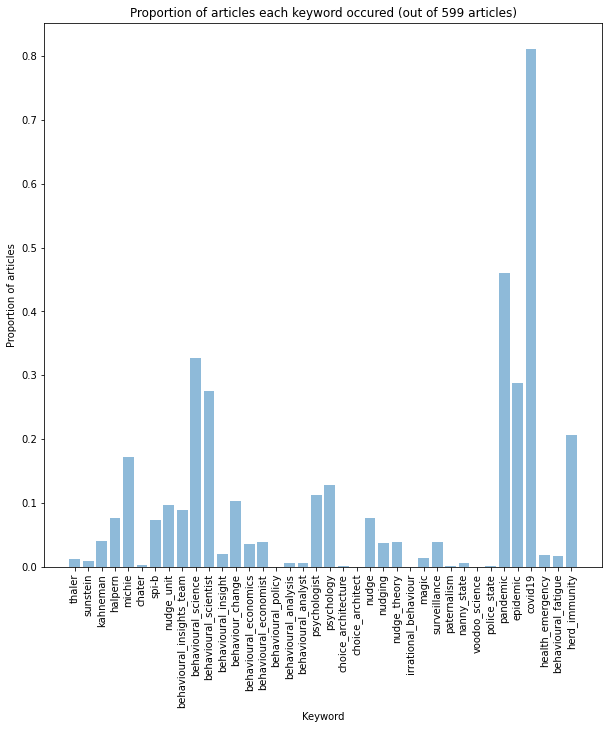

In [16]:
# historgram
fig, ax = plt.subplots(figsize=(10,10))  

plt.bar(prop_kw_article_occurrence.index, prop_kw_article_occurrence.values, align='center', alpha=0.5)
plt.xticks(prop_kw_article_occurrence.index, rotation=90)
plt.xlabel('Keyword')
plt.ylabel('Proportion of articles')
plt.title('Proportion of articles each keyword occured (out of 599 articles)')

plt.show()

## "Joint" frequency of co-occurrence of keywords

Here we use the "binary frequency of keyword occurrence" to compute a co-occurrence matrix. 

This answer the questions: "How many times do pair of keywords co-occur in the same article?" and, consequently, "Which keywords tend to appear together in the same article?".

However, this measure of co-occurrence frequency does not take into account of how frequent each keyword is separately in each article. Thus, .... <TO BE COMPLETED>.  

In [17]:
news_uk.kword_yn_occurrence.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
coccur_matrix = news_uk.kword_yn_occurrence.values.T.dot(news_uk.kword_yn_occurrence.values)

In [19]:
np.fill_diagonal(coccur_matrix, 0)

In [20]:
coccur_matrix

array([[0, 3, 1, ..., 1, 1, 2],
       [3, 0, 0, ..., 0, 2, 2],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 5],
       [1, 2, 0, ..., 0, 0, 3],
       [2, 2, 0, ..., 5, 3, 0]])

In [21]:
keywords_list = list(news_uk.kword_yn_occurrence.columns)

In [22]:
coccur_df = pd.DataFrame(coccur_matrix, index=keywords_list, columns=keywords_list)

In [23]:
coccur_df

thaler  sunstein  kahneman  halpern  michie  \
thaler                          0         3         1        3       0   
sunstein                        3         0         0        2       0   
kahneman                        1         0         0        0       0   
halpern                         3         2         0        0       1   
michie                          0         0         0        1       0   
chater                          0         0         0        0       0   
spi-b                           0         0         0        1       3   
nudge_unit                      4         4         1       32       1   
behavioural_insights_team       4         3         1       29       1   
behavioural_science             3         3         4       11      14   
behavioural_scientist           2         2         1        9      13   
behavioural_insight             1         2         0        4       0   
behaviour_change                0         0         2        0      59   
behavioural_economics           1         1         1        1       0   
behavioural_economist           3         2         1        2       0   
behavioural_policy              0         0         0        0       0   
behavioural_analysis            0         0         0        0       0   
behavioural_analyst             0         0         0        0       0   
psychologist                    3         2        17        8       8   
psychology                      1         2         3        1      27   
choice_architecture             0         0         0        0       0   
choice_architect                0         0         0        0       0   
nudge                           4         4         3        6       1   
nudging                         1         1         0        3       0   
nudge_theory                    2         3         0        1       0   
irrational_behaviour            0         0         0        0       0   
magic                           1         0         0        0       1   
surveillance                    0         0         1        0       0   
paternalism                     0         0         0        0       0   
nanny_state                     0         0         0        0       0   
voodoo_science                  0         0         0        0       0   
police_state                    0         0         0        0       0   
pandemic                        4         4        12       21      53   
epidemic                        1         1         0       22      50   
covid19                         6         5        17       44      97   
health_emergency                1         0         1        4       3   
behavioural_fatigue             1         2         0        1       0   
herd_immunity                   2         2         0       36      17   

                           chater  spi-b  nudge_unit  \
thaler                          0      0           4   
sunstein                        0      0           4   
kahneman                        0      0           1   
halpern                         0      1          32   
michie                          0      3           1   
chater                          0      0           0   
spi-b                           0      0           1   
nudge_unit                      0      1           0   
behavioural_insights_team       0      1          31   
behavioural_science             2     13          13   
behavioural_scientist           1     19          10   
behavioural_insight             0      0           3   
behaviour_change                0      1           0   
behavioural_economics           0      0           1   
behavioural_economist           0      0           2   
behavioural_policy              0      0           0   
behavioural_analysis            0      0           0   
behavioural_analyst             0      0           0   
psychologist                    0      1           7   
psychology          

Let's display it, using a heatmap

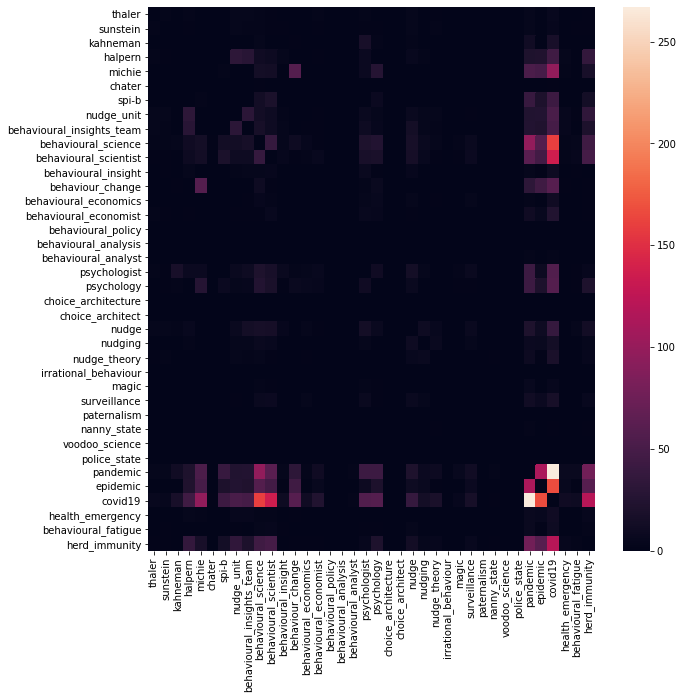

In [24]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(coccur_df, xticklabels=True, yticklabels=True)

Let's only consider the keywords more directly about behavioural science (i.e., no covid19 related)

In [25]:
behsci_kwords = [item for sublist in [CONFIG.get(key) for key in 
                     ['Actors', 'BehavSci', 'Nudge', 'Fatigue', 'Immunity']] for item in sublist] 

In [26]:
behsci_kwords = [col for col in coccur_df.columns if col in behsci_kwords]

In [27]:
behsci_coccur_df = coccur_df.loc[behsci_kwords, behsci_kwords] 

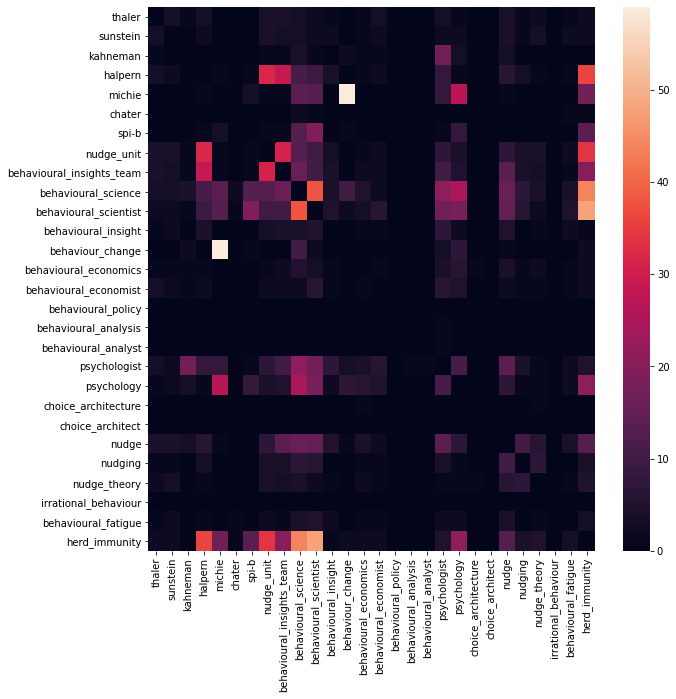

In [28]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(behsci_coccur_df, xticklabels=True, yticklabels=True)

We can observe that:

- "herd immunity" tends to be mentioned in the same articles that also mention "David Halpern", "behavioural science/scientist", "nudge unit/ behavioural insight team"
- "Susan Michie" and "David Halpern" are the two personalities that mostly co-occur with other keywords across the articles. But while Michie is mostly associated with "behaviour change" and discipline names ("behavioural science" and "psychology") and only less so with "herd immunity" or policy-related actors like "nudge unit" or "spi-b", "Halpern" is mostly mentioned in associatio with these latter.
- "herd immunity" is associated more with "behavioural science/scientist" than with "psychology".

# Network: exploring how keywords are interconnected

Let's use python's `networkx` library to plot the "connectedness" of keywords. This should give us an idea of what type of clusters of keywords exist in the articles.

In [29]:
#set 0 to lower triangular matrix, as it is redudent info (i.e., the matrix is symmetric around the digonal)
behsci_coccur_df.values[np.tril(np.ones(behsci_coccur_df.shape)).astype(np.bool)] = 0

In [30]:
behsci_coccur_df

thaler  sunstein  kahneman  halpern  michie  \
thaler                          0         3         1        3       0   
sunstein                        0         0         0        2       0   
kahneman                        0         0         0        0       0   
halpern                         0         0         0        0       1   
michie                          0         0         0        0       0   
chater                          0         0         0        0       0   
spi-b                           0         0         0        0       0   
nudge_unit                      0         0         0        0       0   
behavioural_insights_team       0         0         0        0       0   
behavioural_science             0         0         0        0       0   
behavioural_scientist           0         0         0        0       0   
behavioural_insight             0         0         0        0       0   
behaviour_change                0         0         0        0       0   
behavioural_economics           0         0         0        0       0   
behavioural_economist           0         0         0        0       0   
behavioural_policy              0         0         0        0       0   
behavioural_analysis            0         0         0        0       0   
behavioural_analyst             0         0         0        0       0   
psychologist                    0         0         0        0       0   
psychology                      0         0         0        0       0   
choice_architecture             0         0         0        0       0   
choice_architect                0         0         0        0       0   
nudge                           0         0         0        0       0   
nudging                         0         0         0        0       0   
nudge_theory                    0         0         0        0       0   
irrational_behaviour            0         0         0        0       0   
behavioural_fatigue             0         0         0        0       0   
herd_immunity                   0         0         0        0       0   

                           chater  spi-b  nudge_unit  \
thaler                          0      0           4   
sunstein                        0      0           4   
kahneman                        0      0           1   
halpern                         0      1          32   
michie                          0      3           1   
chater                          0      0           0   
spi-b                           0      0           1   
nudge_unit                      0      0           0   
behavioural_insights_team       0      0           0   
behavioural_science             0      0           0   
behavioural_scientist           0      0           0   
behavioural_insight             0      0           0   
behaviour_change                0      0           0   
behavioural_economics           0      0           0   
behavioural_economist           0      0           0   
behavioural_policy              0      0           0   
behavioural_analysis            0      0           0   
behavioural_analyst             0      0           0   
psychologist                    0      0           0   
psychology                      0      0           0   
choice_architecture             0      0           0   
choice_architect                0      0           0   
nudge                           0      0           0   
nudging                         0      0           0   
nudge_theory                    0      0           0   
irrational_behaviour            0      0           0   
behavioural_fatigue             0      0           0   
herd_immunity                   0      0           0   

                           behavioural_insights_team  behavioural_science  \
thaler                                             4                    3   
sunstein                                           3                    3   
kahneman                

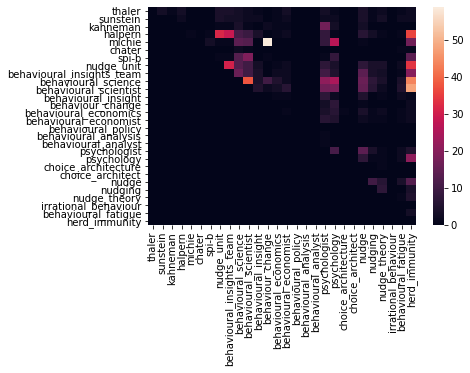

In [31]:
# let's check that it worked as expected
sns.heatmap(behsci_coccur_df, xticklabels=True, yticklabels=True)

In [32]:
# reshape and filter only co-occurrence > 0
# weight represent the count of co-occurrences

behsci_coccur_long = behsci_coccur_df.stack()
behsci_coccur_long = behsci_coccur_long[behsci_coccur_long >= 1].rename_axis(('source', 'target')).reset_index(name='weight')


In [33]:
kword_graph = nx.from_pandas_edgelist(behsci_coccur_long, edge_attr=True)

In [34]:
# take a look at one
print(nx.to_dict_of_dicts(kword_graph).get('michie'))

{'halpern': {'weight': 1}, 'spi-b': {'weight': 3}, 'nudge_unit': {'weight': 1}, 'behavioural_insights_team': {'weight': 1}, 'behavioural_science': {'weight': 14}, 'behavioural_scientist': {'weight': 13}, 'behaviour_change': {'weight': 59}, 'psychologist': {'weight': 8}, 'psychology': {'weight': 27}, 'nudge': {'weight': 1}, 'herd_immunity': {'weight': 17}}


In [35]:
# extract weights, we'll use them for plotting
weights = list(nx.get_edge_attributes(kword_graph,'weight').values())

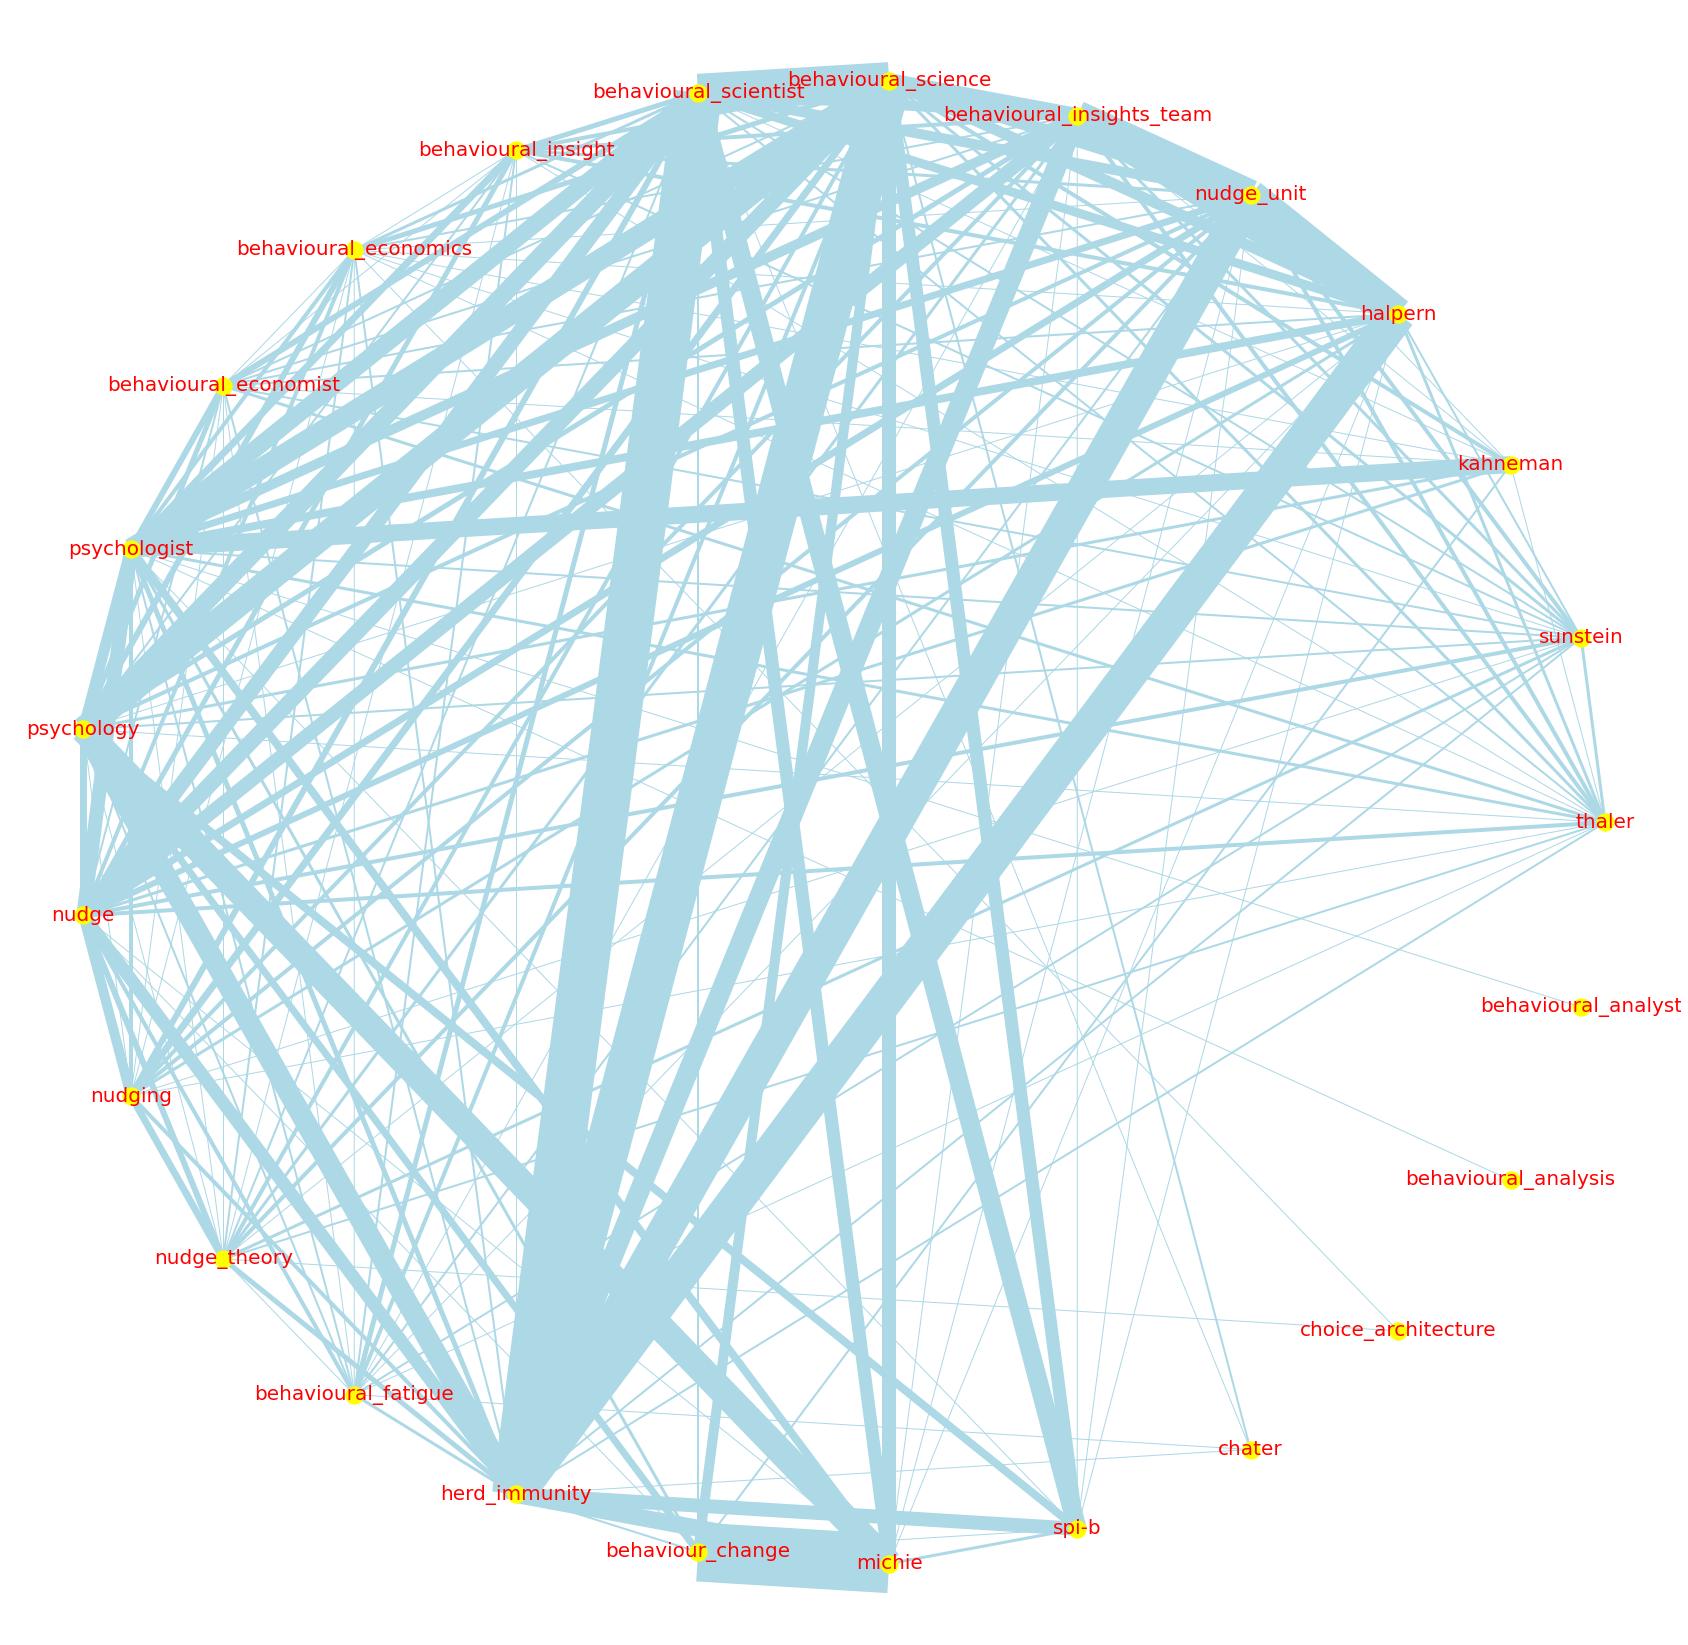

In [36]:
# let's make edges' width proportional to co-occurrence
fig, ax = plt.subplots(figsize=(30,30))   
nx.draw_circular(kword_graph, with_labels=True, 
                 width=weights, 
                 edge_color='lightblue',
                 node_color='yellow',
                 font_size=20,
                 font_color='red',
                 font_weight=2
                )

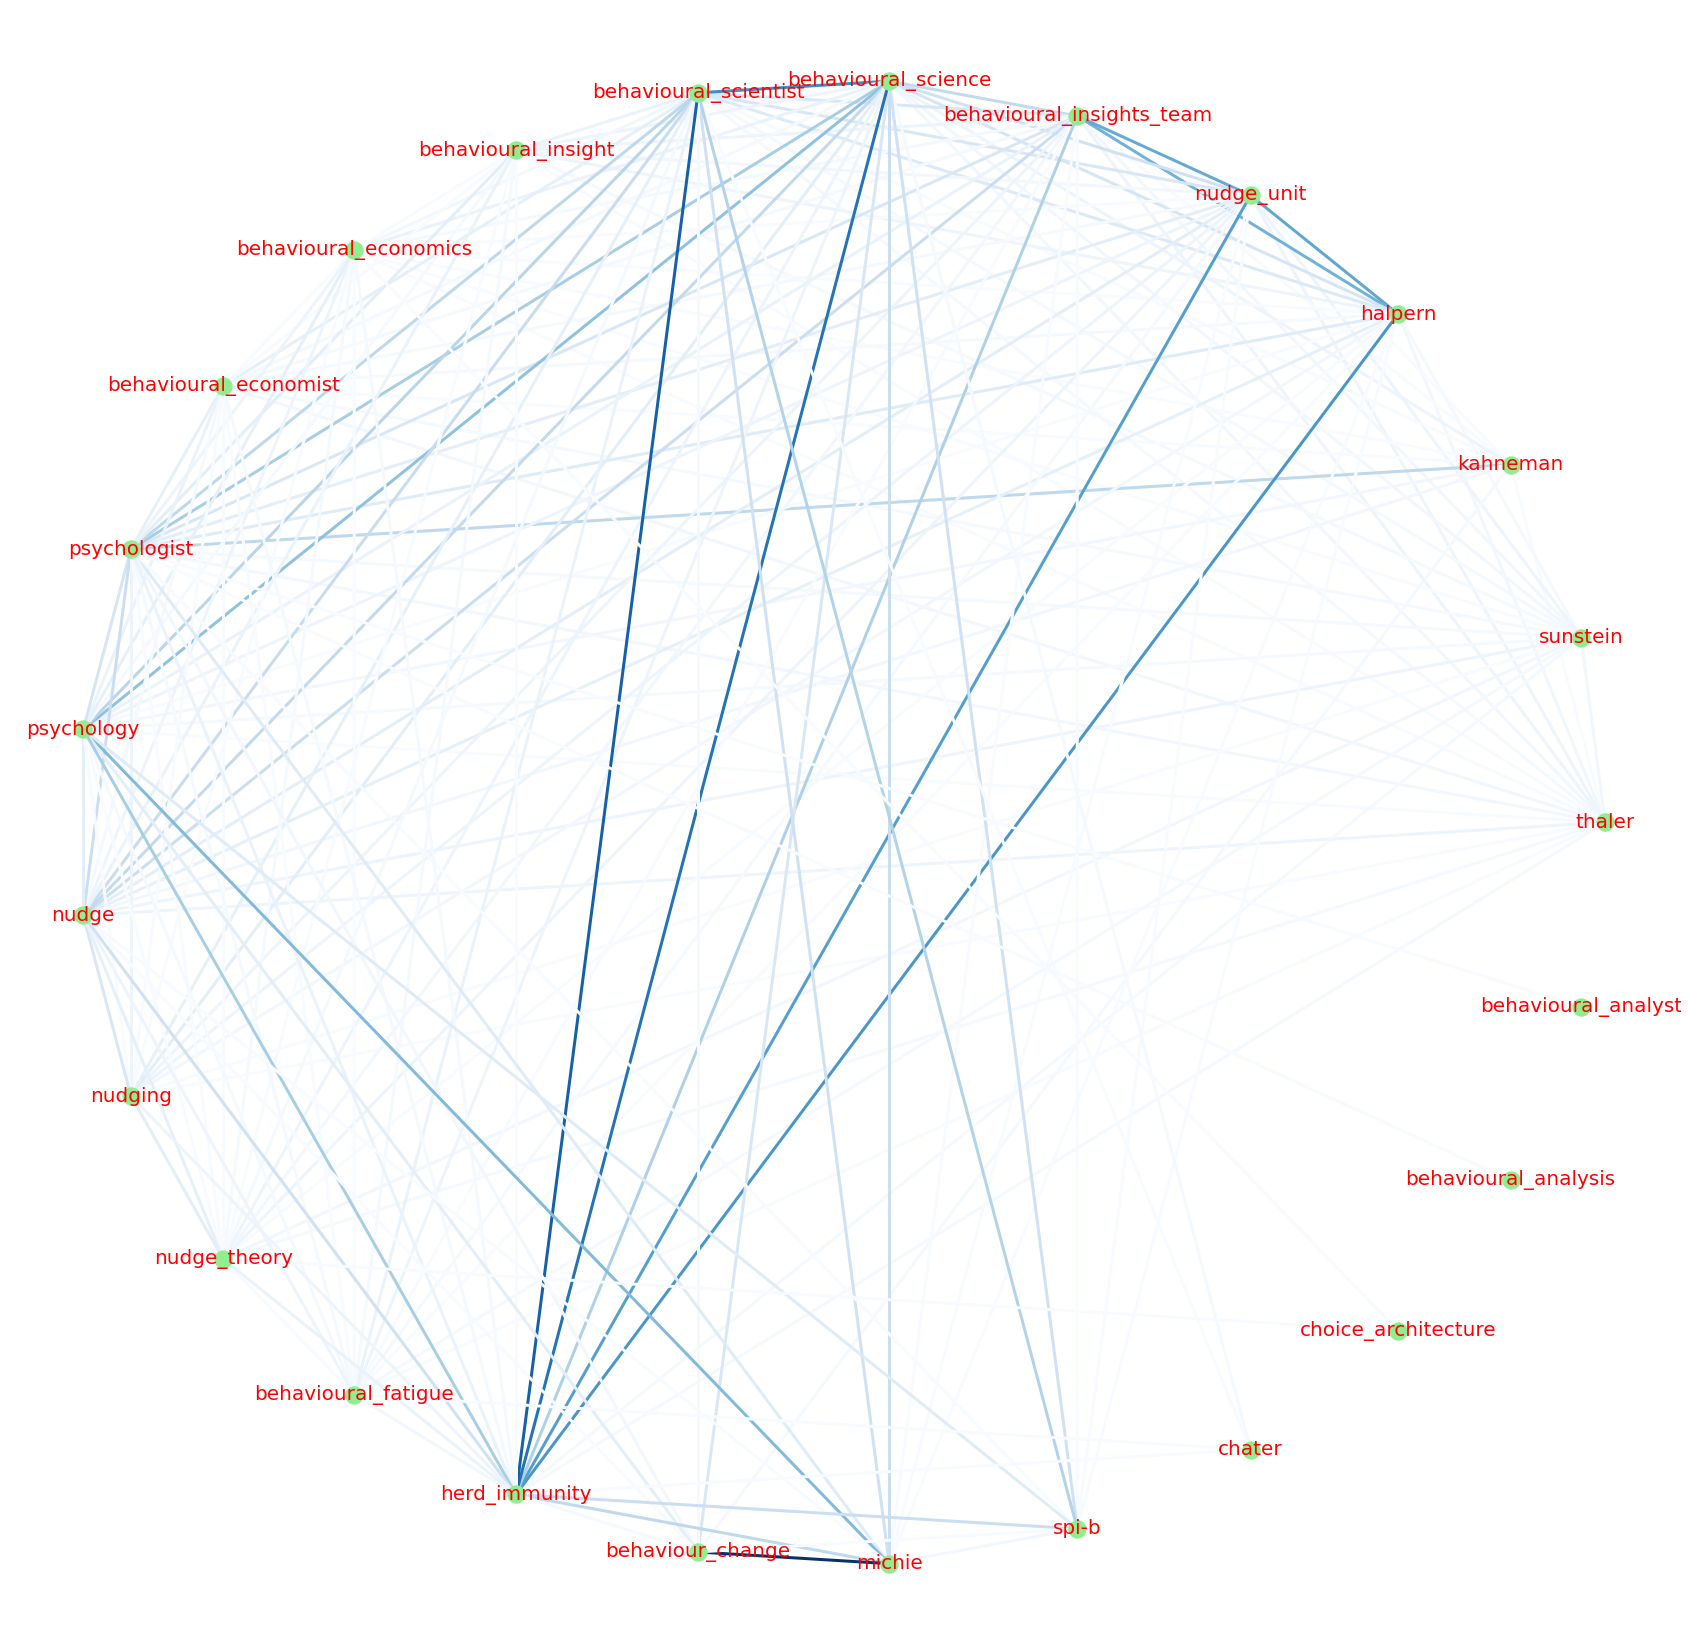

In [37]:
# this time with color of edges to mark co-occurrence
fig, ax = plt.subplots(figsize=(30,30))   
nx.draw_circular(kword_graph, 
                 with_labels=True, 
                 edge_color=weights,
                 width=3,
                 node_color='lightgreen',
                 font_size=20,
                 font_color='red',
                 font_weight=3,
                 edge_cmap=plt.cm.Blues
                )

# Raw frequency of keyword occurrence

## Calculate raw occurrences of keywords per article

Raw frequency of occurrence is the count of how many times a keyword is mentioned in a document.

In [38]:
news_uk.kword_raw_tf

thaler  sunstein  kahneman  halpern  michie  chater  spi-b  \
id  pub_date                                                                 
0   2020-01-23       0         0         0        0       0       0      0   
1   2020-01-23       0         0         0        0       0       0      0   
2   2020-01-23       0         0         0        0       0       0      0   
3   2020-01-23       0         0         0        0       0       0      0   
4   2020-01-26       0         0         0        0       0       0      0   
...                ...       ...       ...      ...     ...     ...    ...   
594 2020-05-10       0         0         0        0       0       0      0   
595 2020-05-10       0         0         0        0       0       0      1   
596 2020-05-10       0         0         0        0       1       0      0   
597 2020-05-10       0         0         0        0       2       0      0   
598 2020-05-10       0         0         0        0       1       0      0   

                nudge_unit  behavioural_insights_team  behavioural_science  \
id  pub_date                                                                 
0   2020-01-23           0                          0                    0   
1   2020-01-23           0                          0                    0   
2   2020-01-23           0                          0                    1   
3   2020-01-23           0                          0                    0   
4   2020-01-26           1                          1                    0   
...                    ...                        ...                  ...   
594 2020-05-10           0                          0                    0   
595 2020-05-10           0                          0                    0   
596 2020-05-10           0                          0                    0   
597 2020-05-10           0                          0                    0   
598 2020-05-10           0                          0                    0   

                ...  paternalism  nanny_state  voodoo_science  police_state  \
id  pub_date    ...                                                           
0   2020-01-23  ...            0            0               0             0   
1   2020-01-23  ...            1            0               0             0   
2   2020-01-23  ...            0            0               0             0   
3   2020-01-23  ...            0            0               0             0   
4   2020-01-26  ...            0            0               0             0   
...             ...          ...          ...             ...           ...   
594 2020-05-10  ...            0            0               0             0   
595 2020-05-10  ...            0            0               0             0   
596 2020-05-10  ...            0            0               0             0   
597 2020-05-10  ...            0            0               0             0   
598 2020-05-10  ...            0            0               0             0   

                pandemic  epidemic  covid19  health_emergency  \
id  pub_date                                                    
0   2020-01-23         0         0        0                 0   
1   2020-01-23         0         0        0                 0   
2   2020-01-23         0         0        0                 0   
3   2020-01-23         0         0        0                 0   
4   2020-01-26         0         0        0                 0   
...                  ...       ...      ...               ...   
594 2020-05-10         0         1        0                 0   
595 2020-05-10         0         0        5                 0   
596 2020-05-10         0         0        2                 0   
597 2020-05-10         3         0        2                 0   
598 2020-05-10         0         0        1                 0   

                behavioural_fatigue  herd_immunity  
id  pub_date                                        
0   20

## Co-occurrence matrix based on raw frequencies

This measure would not only capture whether two keywords occur in the same article, but also how many times they each occur when they co-occur.

For instance, let's suppose that occurrence of keywords is as follow:

- article 1: "kword1" : 10 occurrences, "kword2" : 1, "kword3": 1, "kword4": 1
- article 2: "kword1" : 10 occurrences, "kword2" : 0, "kword3": 1, "kword4": 1
- article 3: "kword1" : 10 occurrences, "kword2" : 0, "kword3": 1, "kword4": 1


Let's take a look at the frequency of co-occurrence of a couple of keyword pairs:

- for "kword1"-"kword2" pair: 10x1 + 10x0 + 10x0 = 10 (even if they actually only co-occured in one article)
- for "kword3"-"kword4" pair: 1x1 + 1x1 + 1x1 = 3 (even if they co-occured in three articles)

It follows that this measure risks to over-value potenitally spurious co-occurrences, and under-value important co-occurrences and could be mis-leading in capturing keyword co-occurrence. 

**For this reason, I am tempted not to explore it further.**

# Length-normalised frequency of keyword occurrence

The next measure of frequency we'll consider is the count of a keyword's occurrences in an article normalised (i.e., devided) by the length of the article. 
This measure accunts for the fact that longer texts may see more occurrences of a keyword than shorter texts just because they are longer (i.e., the possibility that a term would appear more often in longer documents than shorter ones). 

The length of the document is the number of unigram (single words) in the text even if the keyword in question is composed by two words (a bigram) e.g., "behavioural science". We did this as the two word in these cases can be considered as a single word. That is, both the words ("behavioural" and "science") can have independent meaning, however, when they are together, they express a precise, unique concept.

Also note that stopwords (https://www.geeksforgeeks.org/removing-stop-words-nltk-python/) have been removed from all article texts (to decrease "noise").

In [39]:
news_uk.kword_normlen_tf

thaler  sunstein  kahneman  halpern    michie  chater  \
id  pub_date                                                            
0   2020-01-23     0.0       0.0       0.0      0.0  0.000000     0.0   
1   2020-01-23     0.0       0.0       0.0      0.0  0.000000     0.0   
2   2020-01-23     0.0       0.0       0.0      0.0  0.000000     0.0   
3   2020-01-23     0.0       0.0       0.0      0.0  0.000000     0.0   
4   2020-01-26     0.0       0.0       0.0      0.0  0.000000     0.0   
...                ...       ...       ...      ...       ...     ...   
594 2020-05-10     0.0       0.0       0.0      0.0  0.000000     0.0   
595 2020-05-10     0.0       0.0       0.0      0.0  0.000000     0.0   
596 2020-05-10     0.0       0.0       0.0      0.0  0.001608     0.0   
597 2020-05-10     0.0       0.0       0.0      0.0  0.006329     0.0   
598 2020-05-10     0.0       0.0       0.0      0.0  0.002058     0.0   

                   spi-b  nudge_unit  behavioural_insights_team  \
id  pub_date                                                      
0   2020-01-23  0.000000    0.000000                   0.000000   
1   2020-01-23  0.000000    0.000000                   0.000000   
2   2020-01-23  0.000000    0.000000                   0.000000   
3   2020-01-23  0.000000    0.000000                   0.000000   
4   2020-01-26  0.000000    0.003597                   0.003597   
...                  ...         ...                        ...   
594 2020-05-10  0.000000    0.000000                   0.000000   
595 2020-05-10  0.003636    0.000000                   0.000000   
596 2020-05-10  0.000000    0.000000                   0.000000   
597 2020-05-10  0.000000    0.000000                   0.000000   
598 2020-05-10  0.000000    0.000000                   0.000000   

                behavioural_science  ...  paternalism  nanny_state  \
id  pub_date                         ...                             
0   2020-01-23             0.000000  ...     0.000000          0.0   
1   2020-01-23             0.000000  ...     0.001453          0.0   
2   2020-01-23             0.001546  ...     0.000000          0.0   
3   2020-01-23             0.000000  ...     0.000000          0.0   
4   2020-01-26             0.000000  ...     0.000000          0.0   
...                             ...  ...          ...          ...   
594 2020-05-10             0.000000  ...     0.000000          0.0   
595 2020-05-10             0.000000  ...     0.000000          0.0   
596 2020-05-10             0.000000  ...     0.000000          0.0   
597 2020-05-10             0.000000  ...     0.000000          0.0   
598 2020-05-10             0.000000  ...     0.000000          0.0   

                voodoo_science  police_state  pandemic  epidemic   covid19  \
id  pub_date                                                                 
0   2020-01-23             0.0           0.0  0.000000   0.00000  0.000000   
1   2020-01-23             0.0           0.0  0.000000   0.00000  0.000000   
2   2020-01-23             0.0           0.0  0.000000   0.00000  0.000000   
3   2020-01-23             0.0           0.0  0.000000   0.00000  0.000000   
4   2020-01-26             0.0           0.0  0.000000   0.00000  0.000000   
...                        ...           ...       ...       ...       ...   
594 2020-05-10             0.0           0.0  0.000000   0.00207  0.000000   
595 2020-05-10             0.0           0.0  0.000000   0.00000  0.018182   
596 2020-05-10             0.0           0.0  0.000000   0.00000  0.003215   
597 2020-05-10             0.0           0.0  0.009494   0.00000  0.006329   
598 2020-05-10             0.0           0.0  0.000000   0.00000  0.002058   

                health_emergency  behavioural_fatigue  herd_immunity  
id  pub_date                                                          
0   2020-01-23               0.0                  0.0            0.0  
1   2020-01-23               0.0                  0.0  

Let's take a look at the distribution of length-normalised frequency for a few keywords:

In [40]:
# keyword = 'behavioural science'
keyword = 'covid19'

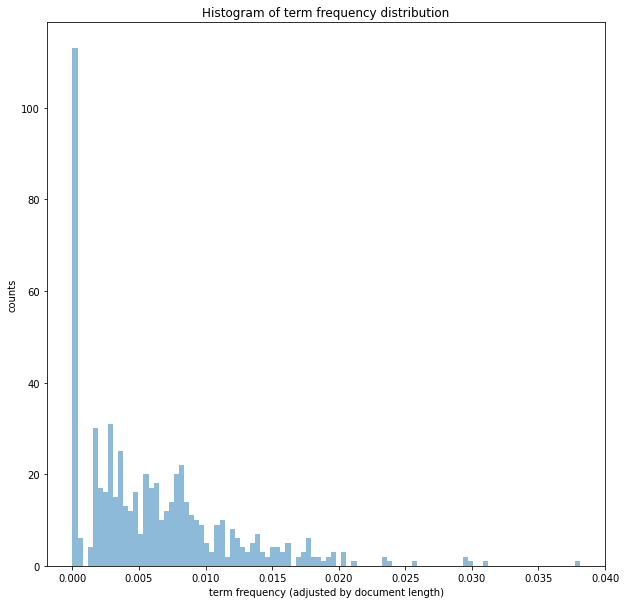

In [41]:
# historgram
fig, ax = plt.subplots(figsize=(10,10))  

plt.hist(news_uk.kword_normlen_tf[keyword], bins=100, align='mid', alpha=0.5)
#plt.xticks(prop_kw_article_occurrence.index, rotation=90)
plt.xlabel('term frequency (adjusted by document length)')
plt.ylabel('counts')
plt.title('Histogram of term frequency distribution')

plt.show()

Even the most common keyword when looking at raw counts, i.e. 'covid19', has very low term frequencies overall when adjusted by documents' length.

# Pointwise Mutual Information (PMI)

The idea of PMI is to quantify the likelihood of co-occurrence of two words, taking into account the fact that it might be caused by the frequency of the single words. In this sense, PMI addresses our concerns about co-occurrence  based on raw frequencies.

PMI is calculated as the (log) probability of co-occurrence scaled by the product of the single probabilities:

`PMI(w1, w2) = log2( P(w1, w2) / P(w1)*P(w2) ) = log2( N*C(w1,w2) / C(w1)*C(w2) )`

- `P(w1)` is the maximum-likelihood estimation (MLE) estimate for `w1` occurring
- `P(w2)` same but for word `w2`
- `P(w1, w2)` is the MLE estimate for the joint frequency (co-occurrence) of `w1` and `w2`.


In [42]:
def pmi(mle_co: float, mle_w1: float, mle_w2: float) -> float:
    return log2(mle_co/(mle_w1*mle_w2))

### How are these MLE estimates computed?

Two main methods in the literature (ref: https://www.aclweb.org/anthology/N03-1032.pdf):

- window-oriented approach
- document-oriented approach

## Window-oriented approach

- Individual word frequency is corpus frequency, i.e., count of occurrences of word `wi` across all corpus. The MLE for word `wi`, its probability of occurrence, is that this count devided by the size of the corpus as total number of words `N`: `P(wi) = count(wi) / N`

- Co-occurrence (joint frequency) of words `wi` and `wj` is the number of windows (of size `t`) where the two words co-occur. So, given number of windows of size `t` in corpus `Nwt`, the co-occurrence probability `P(wi, wj) = count(wi, wj)/Nwt`.

## Document-size approach

- Word frequency is document frequency `df_wi`, i.e., the number of documents in which the word occurs.  
- MLE estimate `P(wi)` is thus the ratio between the number of documents that contain the word (`df_wi`) and the total number of documents (`D`): `df_wi / D`.

- Words co-occurrence is the number of documents where the two words co-occur `df_wiwj` (one could impose a maximum distance within the document for co-occurrence).
- MLE estimate `P(wi, wj)` is the ratio between the number of documents that contain both words `w1` and `w2` and the total number of documents: `df_wiwj / D`.

### Example

Let's consider the following corpus of five texts, and calculate the PMI of keywords `coffee` and `cafe`.
We just report the total number of words (unigrams) in each text in the corpus, and the raw count of word occurences for the two keywords in each text.

This resambles many aspects of our real corpus of news articles and occurrence/co-occurrence of keywords.

In [43]:
corpus = {
    'text1': {'coffee': 4, 'cake': 2, 'n': 100},
    'text2': {'coffee': 2, 'cake': 0, 'n': 60},
    'text3': {'coffee': 1, 'cake': 1, 'n': 80},
    'text4': {'coffee': 2, 'cake': 2, 'n': 100},
    'text5': {'coffee': 3, 'cake': 1, 'n': 40},
}

In [44]:
corpus_df = pd.DataFrame(corpus).T

In [45]:
corpus_df

coffee  cake    n
text1       4     2  100
text2       2     0   60
text3       1     1   80
text4       2     2  100
text5       3     1   40

#### Window-oriented approach

Our **window will still be a whole text** as we are interested in when keywords are discussed together and we take a whole article as the unit of this discussion. Thus:

In [46]:
N = corpus_df.n.sum()    # count of all unigrams
print("N =",N)

N = 380


In [47]:
P_coffee = corpus_df.coffee.sum() / N
P_cake = corpus_df.cake.sum() / N
print("P_coffee =", P_coffee)
print("P_cake =", P_cake)

P_coffee = 0.031578947368421054
P_cake = 0.015789473684210527


In [48]:
Nwt = len(corpus_df.index)    # number of windows, in this case number of unique texts in the corpus
print("Nwt =", Nwt)

Nwt = 5


Number of articles where both keywords occur.

In [49]:
P_coffe_and_cake = corpus_df[(corpus_df.coffee > 0) & (corpus_df.cake > 0)].shape[0] / Nwt
print("P_coffe_and_cake =", P_coffe_and_cake)

P_coffe_and_cake = 0.8


In [50]:
winPMI = pmi(mle_co=P_coffe_and_cake, mle_w1=P_coffee, mle_w2=P_cake)
print("window-PMI of `coffee` and `cake` =", winPMI)

window-PMI of `coffee` and `cake` = 10.64785812033222


So, the window approach (where window size is the whole text) suggest that `coffee` and `cake` co-occur in the corpus more frequently than it'd be expected by chance (if they were independent).

#### Document-oriented approach

In [51]:
D = corpus_df.shape[0]    # number of documents
print("D =", D)

D = 5


In [52]:
P_coffee = corpus_df[corpus_df.coffee > 0].shape[0] / D
P_cake = corpus_df[corpus_df.cake > 0].shape[0] / D
print("P_coffee =", P_coffee)
print("P_cake =", P_cake)

P_coffee = 1.0
P_cake = 0.8


In [53]:
P_coffe_and_cake = corpus_df[(corpus_df.coffee > 0) & (corpus_df.cake > 0)].shape[0] / D
print("P_coffe_and_cake =", P_coffe_and_cake)

P_coffe_and_cake = 0.8


In [54]:
docPMI = pmi(mle_co=P_coffe_and_cake, mle_w1=P_coffee, mle_w2=P_cake)
print("document-PMI of `coffee` and `cake` =", docPMI)

document-PMI of `coffee` and `cake` = 0.0


So, the document approach suggests that coffee and cake are independent in our corpus!

## Let's apply window-PMI and document-PMI to our corpus of news articles

First, let's take a look at the corpus frequency and document frequency of the keywords.

#### Corpus frequency
Count of a keyword' occurrences (across all documents) devided by the length of the corpus as total number of unigrams.

Raw frequency (raw count of all occurrences across all articles)

In [56]:
kword_rawfreqs = news_uk.kword_raw_tf.sum()

In [66]:
kword_rawfreqs.sort_values(ascending=False)

covid19                      2392
pandemic                      579
epidemic                      577
herd_immunity                 360
behavioural_science           231
behavioural_scientist         200
michie                        174
spi-b                         117
psychologist                   89
psychology                     86
halpern                        74
nudge_unit                     69
nudge                          67
behaviour_change               67
behavioural_insights_team      63
kahneman                       29
nudge_theory                   28
surveillance                   27
nudging                        25
behavioural_economics          24
behavioural_economist          23
behavioural_fatigue            17
behavioural_insight            15
health_emergency               13
thaler                         12
magic                          12
sunstein                        8
behavioural_analysis            3
nanny_state                     3
behavioural_an

Notes - these frequency have been double-checked manually and were confirmed:
- "voodoo science" never appears. "voodoo" (without science) appears.
- "choice architect(s)" never appears ("choice architecture" does).
- "irrational behaviour" never appears.
- "chater" only appears twice.

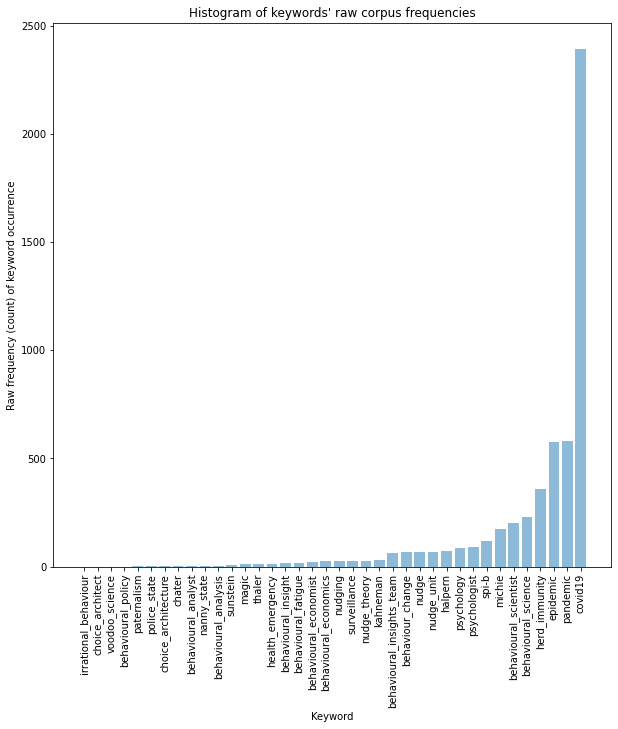

In [71]:
kword_rawfreqs = kword_rawfreqs.sort_values()
# historgram
fig, ax = plt.subplots(figsize=(10,10))  

plt.bar(kword_rawfreqs.index, kword_rawfreqs.values, align='center', alpha=0.5)
plt.xticks(prop_kw_article_occurrence.index, rotation=90)
plt.xlabel('Keyword')
plt.ylabel('Raw frequency (count) of keyword occurrence')
plt.title("Histogram of keywords' raw corpus frequencies")

plt.show()

Relative frequency

In [69]:
kword_corpus_relfreqs = (news_uk.kword_raw_tf.sum() / sum(news_uk.unigram_count_perdoc)).sort_values()

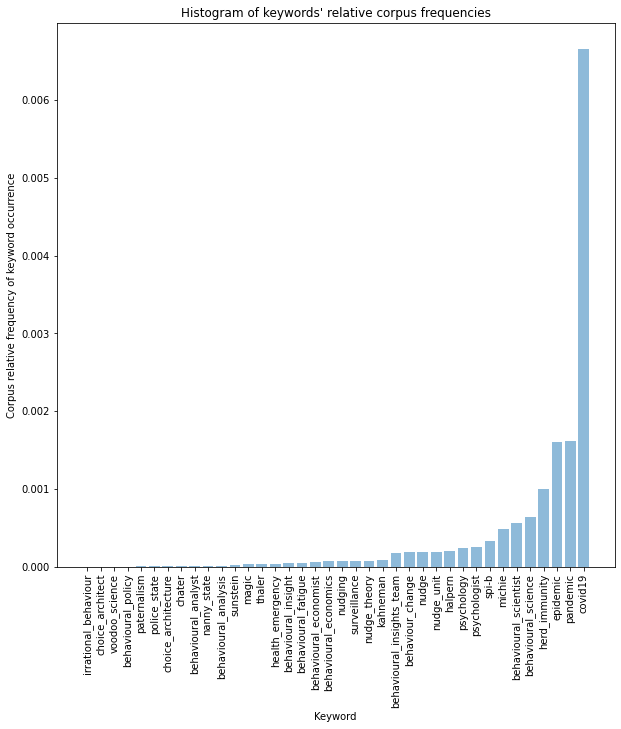

In [70]:
# historgram
fig, ax = plt.subplots(figsize=(10,10))  

plt.bar(kword_corpus_relfreqs.index, kword_corpus_relfreqs.values, align='center', alpha=0.5)
plt.xticks(prop_kw_article_occurrence.index, rotation=90)
plt.xlabel('Keyword')
plt.ylabel('Corpus relative frequency of keyword occurrence')
plt.title("Histogram of keywords' relative corpus frequencies")

plt.show()

#### Document frequency
Count of the number of articles a keyword occurred (regardless of how many times in the same article) devided by the total number of documents.

Raw document count

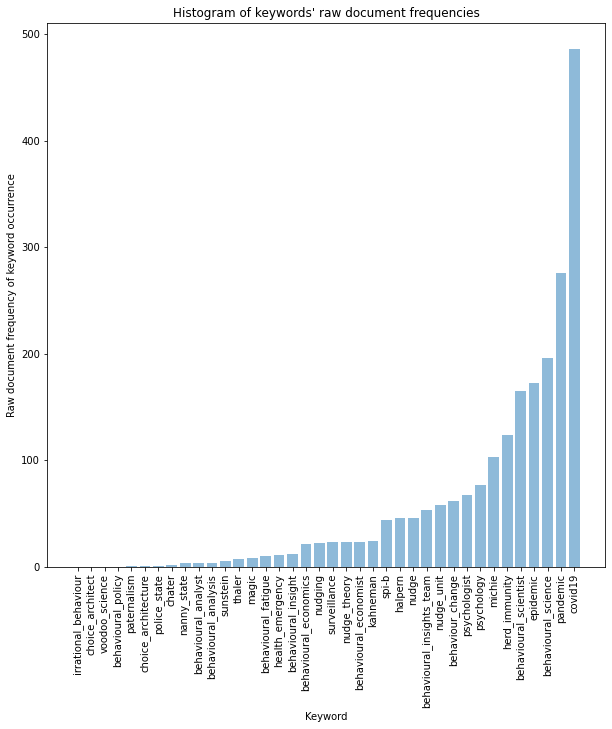

In [72]:
kword_rawdocfreqs = news_uk.kword_yn_occurrence.sum(axis=0).sort_values()

# historgram
fig, ax = plt.subplots(figsize=(10,10))  

plt.bar(kword_rawdocfreqs.index, kword_rawdocfreqs.values, align='center', alpha=0.5)
plt.xticks(prop_kw_article_occurrence.index, rotation=90)
plt.xlabel('Keyword')
plt.ylabel('Raw document frequency of keyword occurrence')
plt.title("Histogram of keywords' raw document frequencies")

plt.show()

Relative document frequency

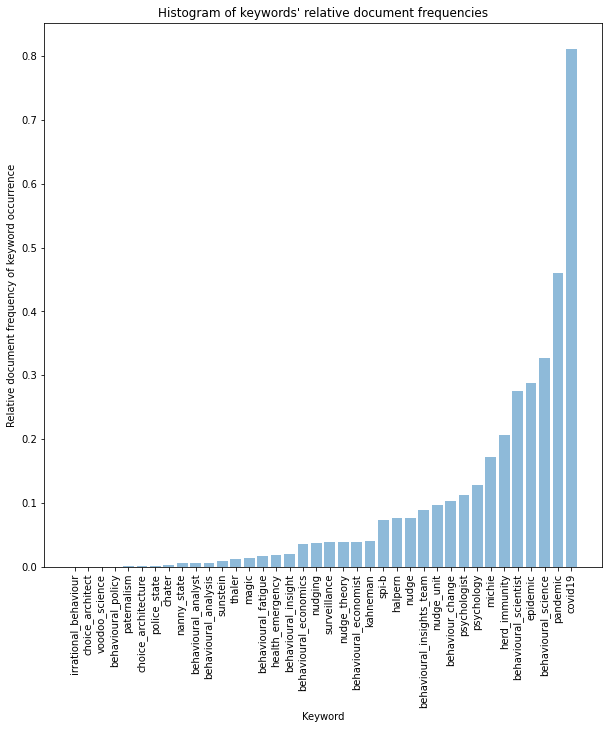

In [74]:
kword_reldocfreqs = (news_uk.kword_yn_occurrence.sum(axis=0) / news_uk.kword_yn_occurrence.shape[0]).sort_values()

# historgram
fig, ax = plt.subplots(figsize=(10,10))  

plt.bar(kword_reldocfreqs.index, kword_reldocfreqs.values, align='center', alpha=0.5)
plt.xticks(prop_kw_article_occurrence.index, rotation=90)
plt.xlabel('Keyword')
plt.ylabel('Relative document frequency of keyword occurrence')
plt.title("Histogram of keywords' relative document frequencies")

plt.show()

## PMI

### Window approach

Note: even if some of our keywords are bigrams (e.g., "nudge unit"), for the calculation of `P("nudge unit") as count("nudge unit") / N`, I will compute `N` as the total count of **unigrams** across articles and by replacing the bigram in question ("nudge unit") and a corrisponding unigram ("nudge_unit"). 

I did this because I believe that the two words in these cases can be considered as a single word. That is, both the words ("nudge" and "unit") can have independent meaning, however, when they are together, they express a precise, unique concept. 

Also, if we consider them as bigrams, it'd we'll have to devide by total number of unigrams and bigrams and trigrams (one of the keyword is a trigram: 'behavioural insights team'). 

In [15]:
news_uk.kword_raw_tf

id   pub_date  
0    2020-01-23    0
1    2020-01-23    0
2    2020-01-23    0
3    2020-01-23    0
4    2020-01-26    0
                  ..
594  2020-05-10    0
595  2020-05-10    0
596  2020-05-10    0
597  2020-05-10    0
598  2020-05-10    0
Name: behavioural_science, Length: 599, dtype: int64

In [62]:
# get unigram count per document and sum them up
N_uni = sum(news_uk.unigram_count_perdoc)
print(N_uni)

359136


MLE estimate for individual word occurrence = corpus frequency

In [72]:
P_kwords = news_uk.kword_raw_tf.sum() / N_uni
print(P_kwords)

thaler                       0.000033
sunstein                     0.000022
kahneman                     0.000081
halpern                      0.000206
michie                       0.000484
chater                       0.000006
spi-b                        0.000326
nudge_unit                   0.000192
behavioural_insights_team    0.000175
behavioural_science          0.000643
behavioural_scientist        0.000557
behavioural_insight          0.000042
behaviour_change             0.000187
behavioural_economics        0.000067
behavioural_economist        0.000064
behavioural_policy           0.000000
behavioural_analysis         0.000008
behavioural_analyst          0.000008
psychologist                 0.000248
psychology                   0.000239
choice_architecture          0.000003
choice_architect             0.000000
nudge                        0.000187
nudging                      0.000070
nudge_theory                 0.000078
irrational_behaviour         0.000000
magic       

MLE estimate of co-occurrence for each keyword pair

In [94]:
# number of windows (articles, in our case)
Nwt = 599

In [77]:
coccur_mat_doc = news_uk.kword_yn_occurrence.values.T.dot(news_uk.kword_yn_occurrence.values)
np.fill_diagonal(coccur_mat_doc, 0)

In [79]:
kwords = news_uk.kword_yn_occurrence.columns

In [80]:
coccur_mat_doc = pd.DataFrame(coccur_mat_doc, index=kwords, columns=kwords)

In [84]:
# reshape
coccur_mat_doc = coccur_mat_doc.stack()


In [96]:
P_cooccurence = coccur_mat_doc.rename_axis(('source', 'target')) / Nwt

In [97]:
P_cooccurence

source         target             
thaler         thaler                 0.000000
               sunstein               0.005008
               kahneman               0.001669
               halpern                0.005008
               michie                 0.000000
                                        ...   
herd_immunity  epidemic               0.100167
               covid19                0.200334
               health_emergency       0.008347
               behavioural_fatigue    0.005008
               herd_immunity          0.000000
Length: 1444, dtype: float64

In [260]:
from itertools import combinations

def _window_PMI(w1, w2):
    try:
        return log2(P_cooccurence[w1][w2]/(P_kwords[w1]*P_kwords[w2]))
    except (ValueError, ZeroDivisionError) as err: # log2(0) or log2(Inf) as either co-occurrence or one occurrence probability is zero
        return np.nan
    

In [261]:
def window_PMI(kwords_list: list) -> list:
    pmis = []
    for pair in combinations(kwords, r=2):
        pmis.append((*pair, _window_PMI(*pair)))
    return pmis

In [262]:
window_pmis = window_PMI(kwords)

<ipython-input-260-29a0c74ce283>:5: RuntimeWarning: invalid value encountered in double_scalars
  return log2(P_cooccurence[w1][w2]/(P_kwords[w1]*P_kwords[w2]))


In [239]:
# window_pmis

In [233]:
window_pmis_df = pd.DataFrame(window_pmis, columns=['source', 'target', 'weight'])

In [234]:
# drop NaN cases
window_pmis_df.dropna(inplace=True)

In [235]:
wind_pmi_kword_graph = nx.from_pandas_edgelist(window_pmis_df, edge_attr=True)

In [236]:
# take a look at one
print(nx.to_dict_of_dicts(wind_pmi_kword_graph).get('michie'))

{'halpern': {'weight': 14.029532448277502}, 'spi-b': {'weight': 14.953583595044202}, 'nudge_unit': {'weight': 14.130461357128281}, 'behavioural_insights_team': {'weight': 14.261705890406535}, 'behavioural_science': {'weight': 16.194591694548}, 'behavioural_scientist': {'weight': 16.295569342272817}, 'behaviour_change': {'weight': 20.055539672810518}, 'psychologist': {'weight': 16.763252382940053}, 'psychology': {'weight': 18.567608561367823}, 'nudge': {'weight': 14.172896623448679}, 'magic': {'weight': 16.654023313185295}, 'pandemic': {'weight': 16.789486730480412}, 'epidemic': {'weight': 16.710414495035693}, 'covid19': {'weight': 15.614896981895473}, 'health_emergency': {'weight': 18.123508596486516}, 'herd_immunity': {'weight': 15.834595558827116}}


#### Network based on window-PMI

In [237]:
# extract weights, we'll use them for plotting
win_pmi_weights = list(nx.get_edge_attributes(wind_pmi_kword_graph,'weight').values())

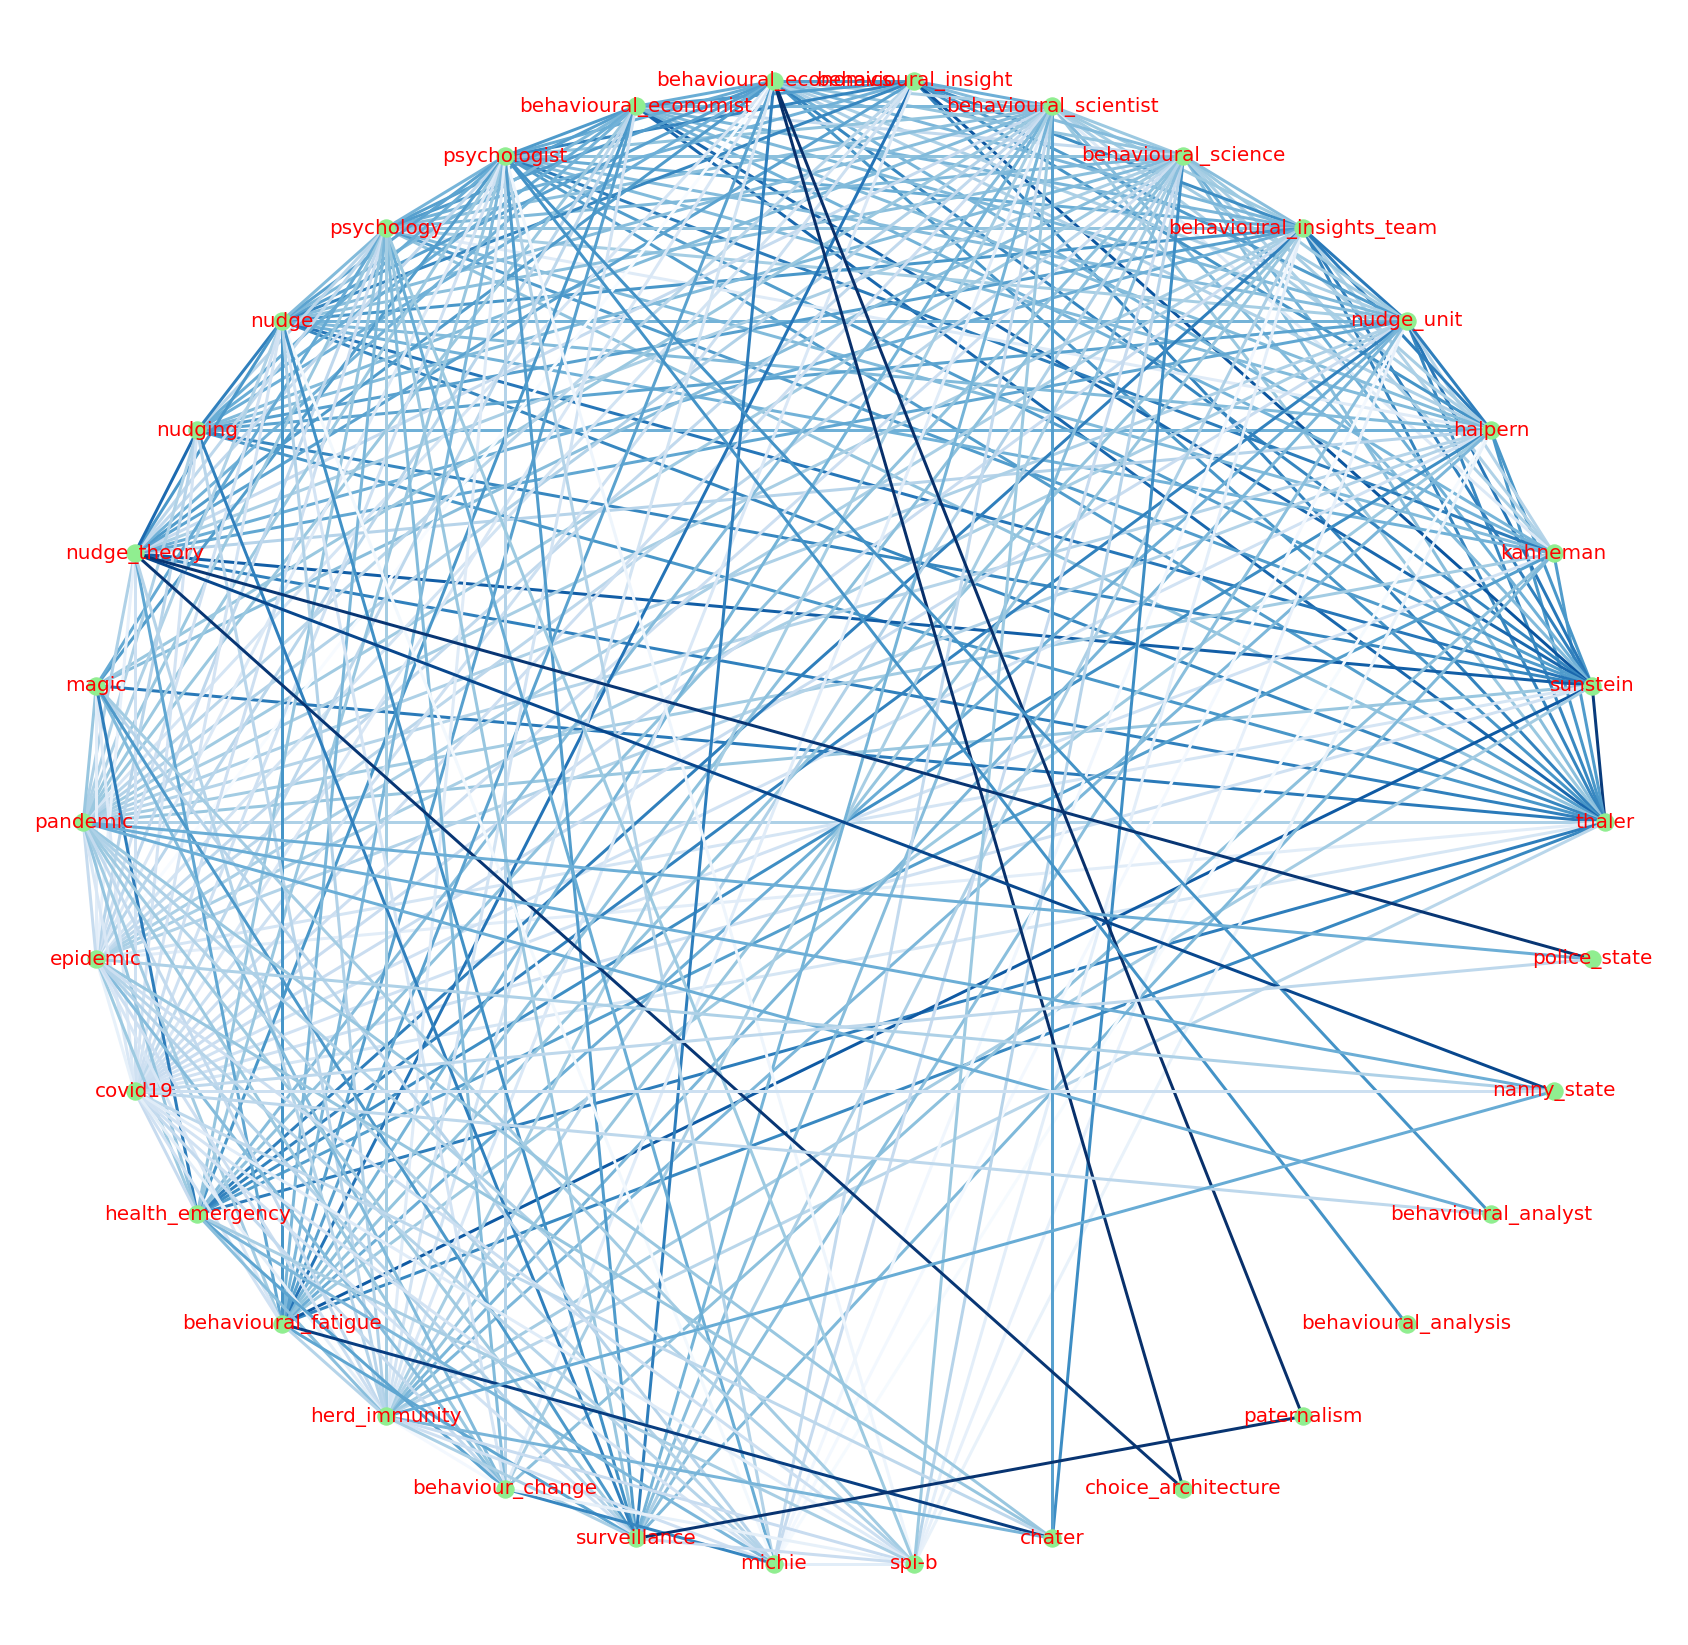

In [238]:
fig, ax = plt.subplots(figsize=(30,30))   
nx.draw_circular(wind_pmi_kword_graph, 
                 with_labels=True, 
                 edge_color=win_pmi_weights,
                 width=3,
                 node_color='lightgreen',
                 font_size=20,
                 font_color='red',
                 font_weight=3,
                 edge_cmap=plt.cm.Blues
                )

### Document approach

In [246]:
# Number of documents

D = news_uk.data.shape[0]

MLE estimate for individual word occurrence = document frequency

In [254]:
# number of article the word appears / total number of articles
docP_kwords = news_uk.kword_yn_occurrence.sum(axis=0) / D

MLE estimate of co-occurrence for each keyword pair

In [256]:
# same co-occurrence matrix produced for the window method (where window size = whole article)
docP_cooccurrence = coccur_mat_doc / D

In [263]:
from itertools import combinations

def _doc_PMI(w1, w2):
    try:
        return log2(docP_cooccurrence[w1][w2]/(docP_kwords[w1]*docP_kwords[w2]))
    except (ValueError, ZeroDivisionError) as err: # log2(0) or log2(Inf) as either co-occurrence or one occurrence probability is zero
        return np.nan
    

In [264]:
def doc_PMI(kwords_list: list) -> list:
    pmis = []
    for pair in combinations(kwords, r=2):
        pmis.append((*pair, _doc_PMI(*pair)))
    return pmis

In [266]:
doc_pmis = doc_PMI(kwords)

<ipython-input-263-7823b8dc0135>:5: RuntimeWarning: invalid value encountered in double_scalars
  return log2(docP_cooccurrence[w1][w2]/(docP_kwords[w1]*docP_kwords[w2]))


In [284]:
doc_pmis_df = pd.DataFrame(doc_pmis, columns=['source', 'target', 'weight'])

In [285]:
# drop NaN cases
doc_pmis_df.dropna(inplace=True)

In [286]:
# drop NEGATIVE VALUES (those pairs of keywords whose co-occurrence is unlikley given their individual occurrence )
# should probably color them differently instead
doc_pos_pmis_df = doc_pmis_df[doc_pmis_df.weight > 0]

In [287]:
doc_pos_pmi_kword_graph = nx.from_pandas_edgelist(doc_pos_pmis_df, edge_attr=True)

In [288]:
# take a look at one
print(nx.to_dict_of_dicts(doc_pos_pmi_kword_graph).get('michie'))

{'behaviour_change': {'weight': 2.4683584045805333}, 'psychology': {'weight': 1.0280126270741343}, 'pandemic': {'weight': 0.15930766339059715}, 'epidemic': {'weight': 0.7575031006781939}, 'covid19': {'weight': 0.215012004186914}, 'health_emergency': {'weight': 0.6654425476894261}}


#### Network based on document-PMI

In [289]:
# extract weights, we'll use them for plotting
doc_pos_pmi_weights = list(nx.get_edge_attributes(doc_pos_pmi_kword_graph,'weight').values())

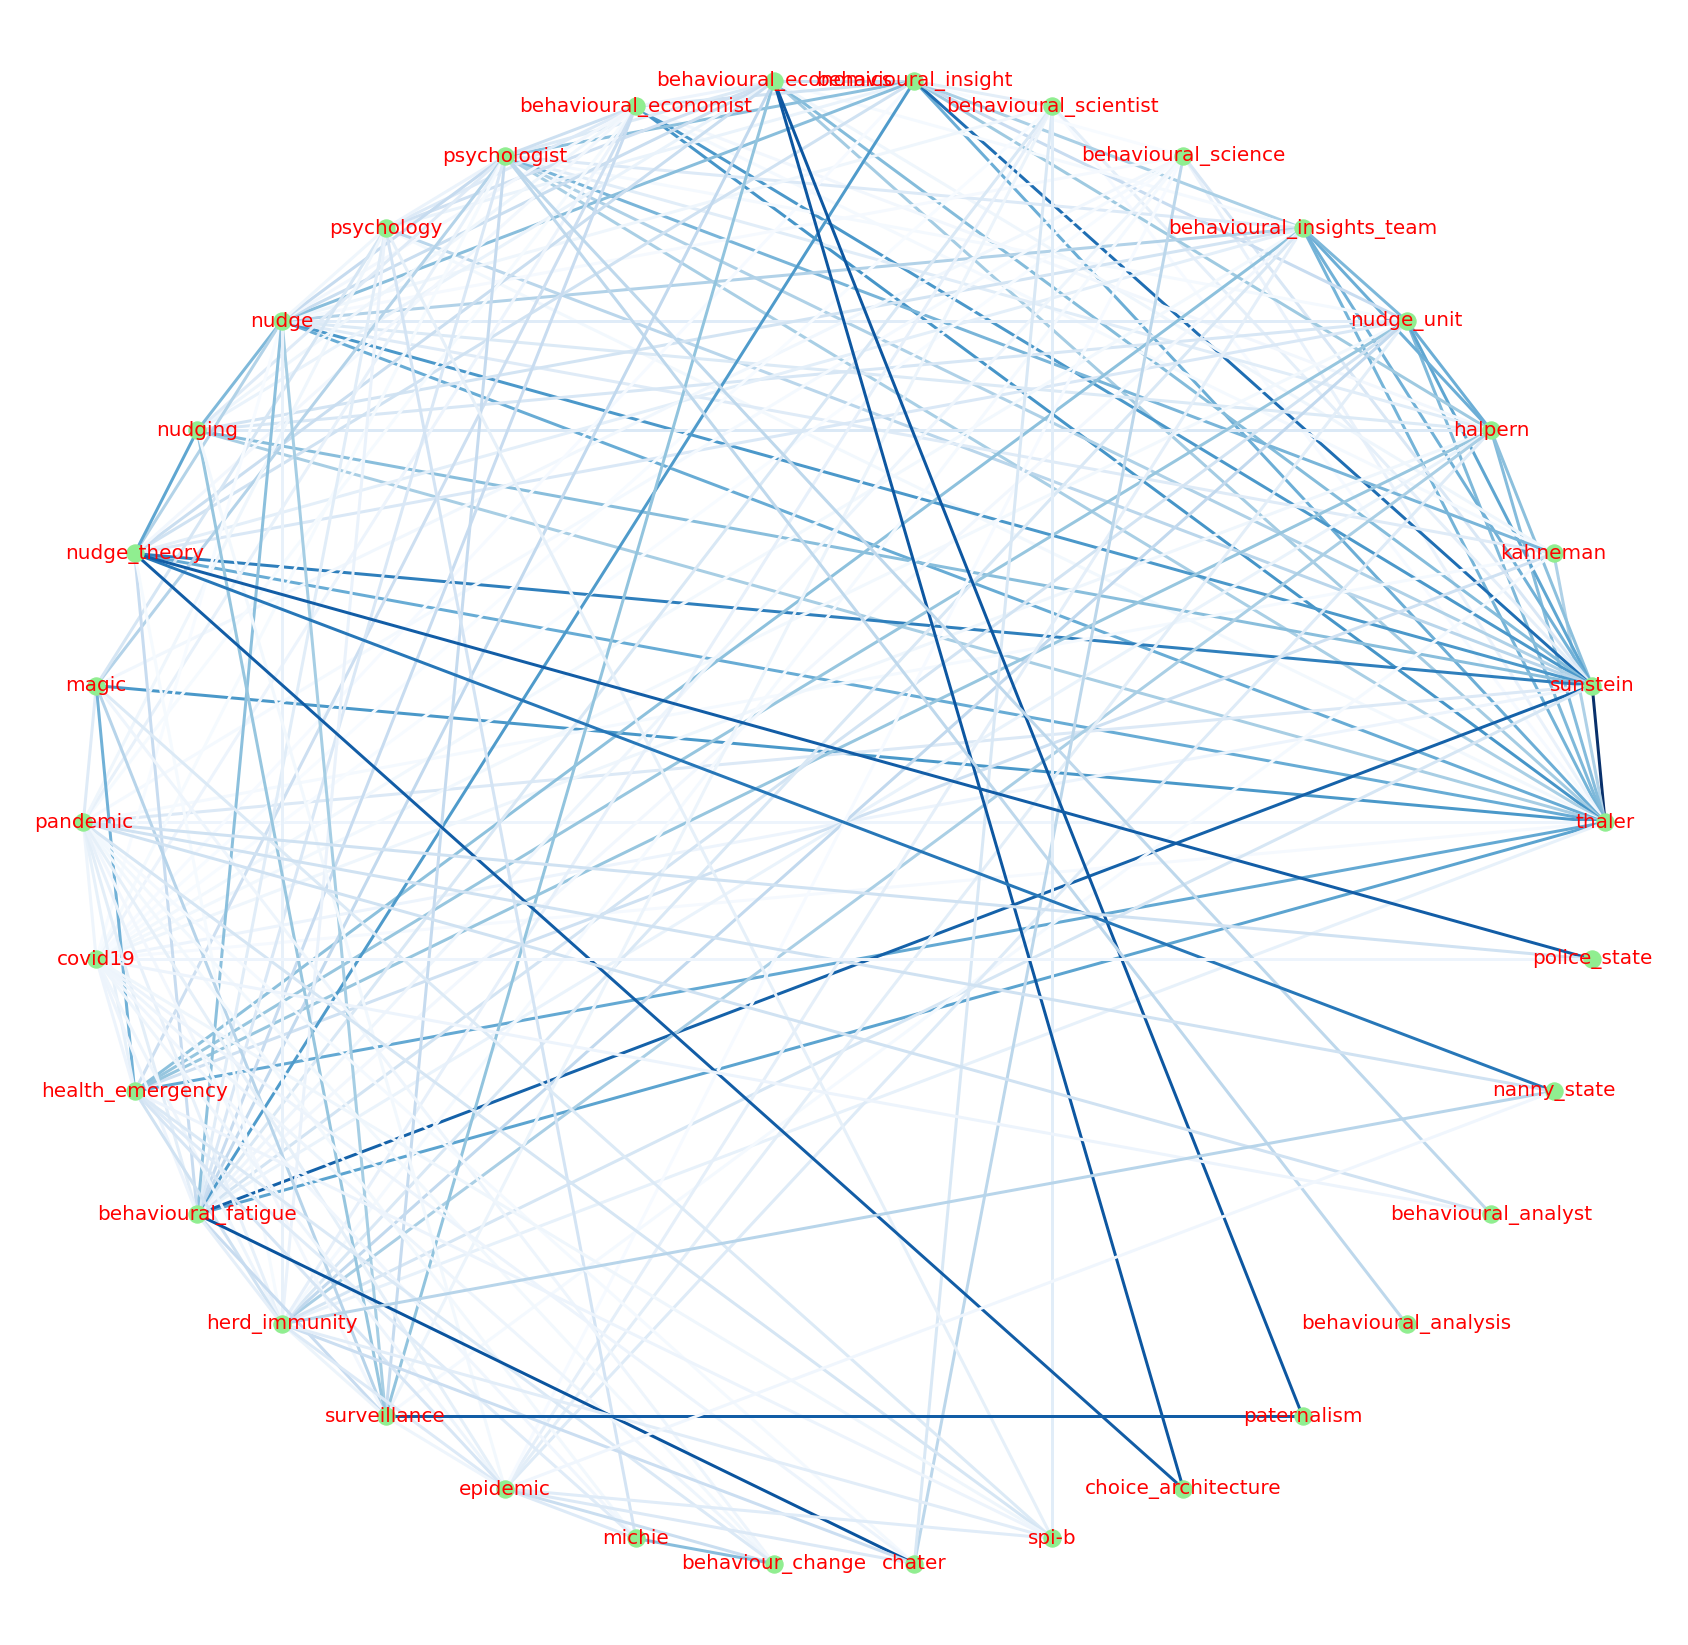

In [290]:
fig, ax = plt.subplots(figsize=(30,30))   
nx.draw_circular(doc_pos_pmi_kword_graph, 
                 with_labels=True, 
                 edge_color=doc_pos_pmi_weights,
                 width=3,
                 node_color='lightgreen',
                 font_size=20,
                 font_color='red',
                 font_weight=3,
                 edge_cmap=plt.cm.Blues
                )

### Pairs of keywords that do not tend to be "dicussed" together

Let's take a look at those pairs of keywords that tend to be less likely to occur together in the same articles based on what would be expected based on their individual frequencies:

In [291]:
NEG_doc_pmis_df = doc_pmis_df[doc_pmis_df.weight < 0]

In [307]:
NEG_doc_pmis_df.assign(abs_weight = NEG_doc_pmis_df.weight.abs().to_list())

source                     target    weight  abs_weight
32         thaler                   epidemic  1.007207    1.007207
68       sunstein                   epidemic  0.521781    0.521781
77       kahneman                 nudge_unit  1.216531    1.216531
78       kahneman  behavioural_insights_team  1.086471    1.086471
79       kahneman        behavioural_science  0.973260    0.973260
..            ...                        ...       ...         ...
643         magic                   epidemic  1.199853    1.199853
644         magic                    covid19  0.376472    0.376472
654  surveillance                    covid19  0.221962    0.221962
671   nanny_state                    covid19  0.283363    0.283363
695      epidemic        behavioural_fatigue  0.521781    0.521781

[102 rows x 4 columns]

In [311]:
doc_neg_pmi_kword_graph = nx.from_pandas_edgelist(NEG_doc_pmis_df, edge_attr='abs_weight')

In [312]:
doc_neg_pmi_kword_graph

In [315]:
# extract weights, we'll use them for plotting
doc_neg_pmi_weights = list(nx.get_edge_attributes(doc_neg_pmi_kword_graph,'abs_weight').values())

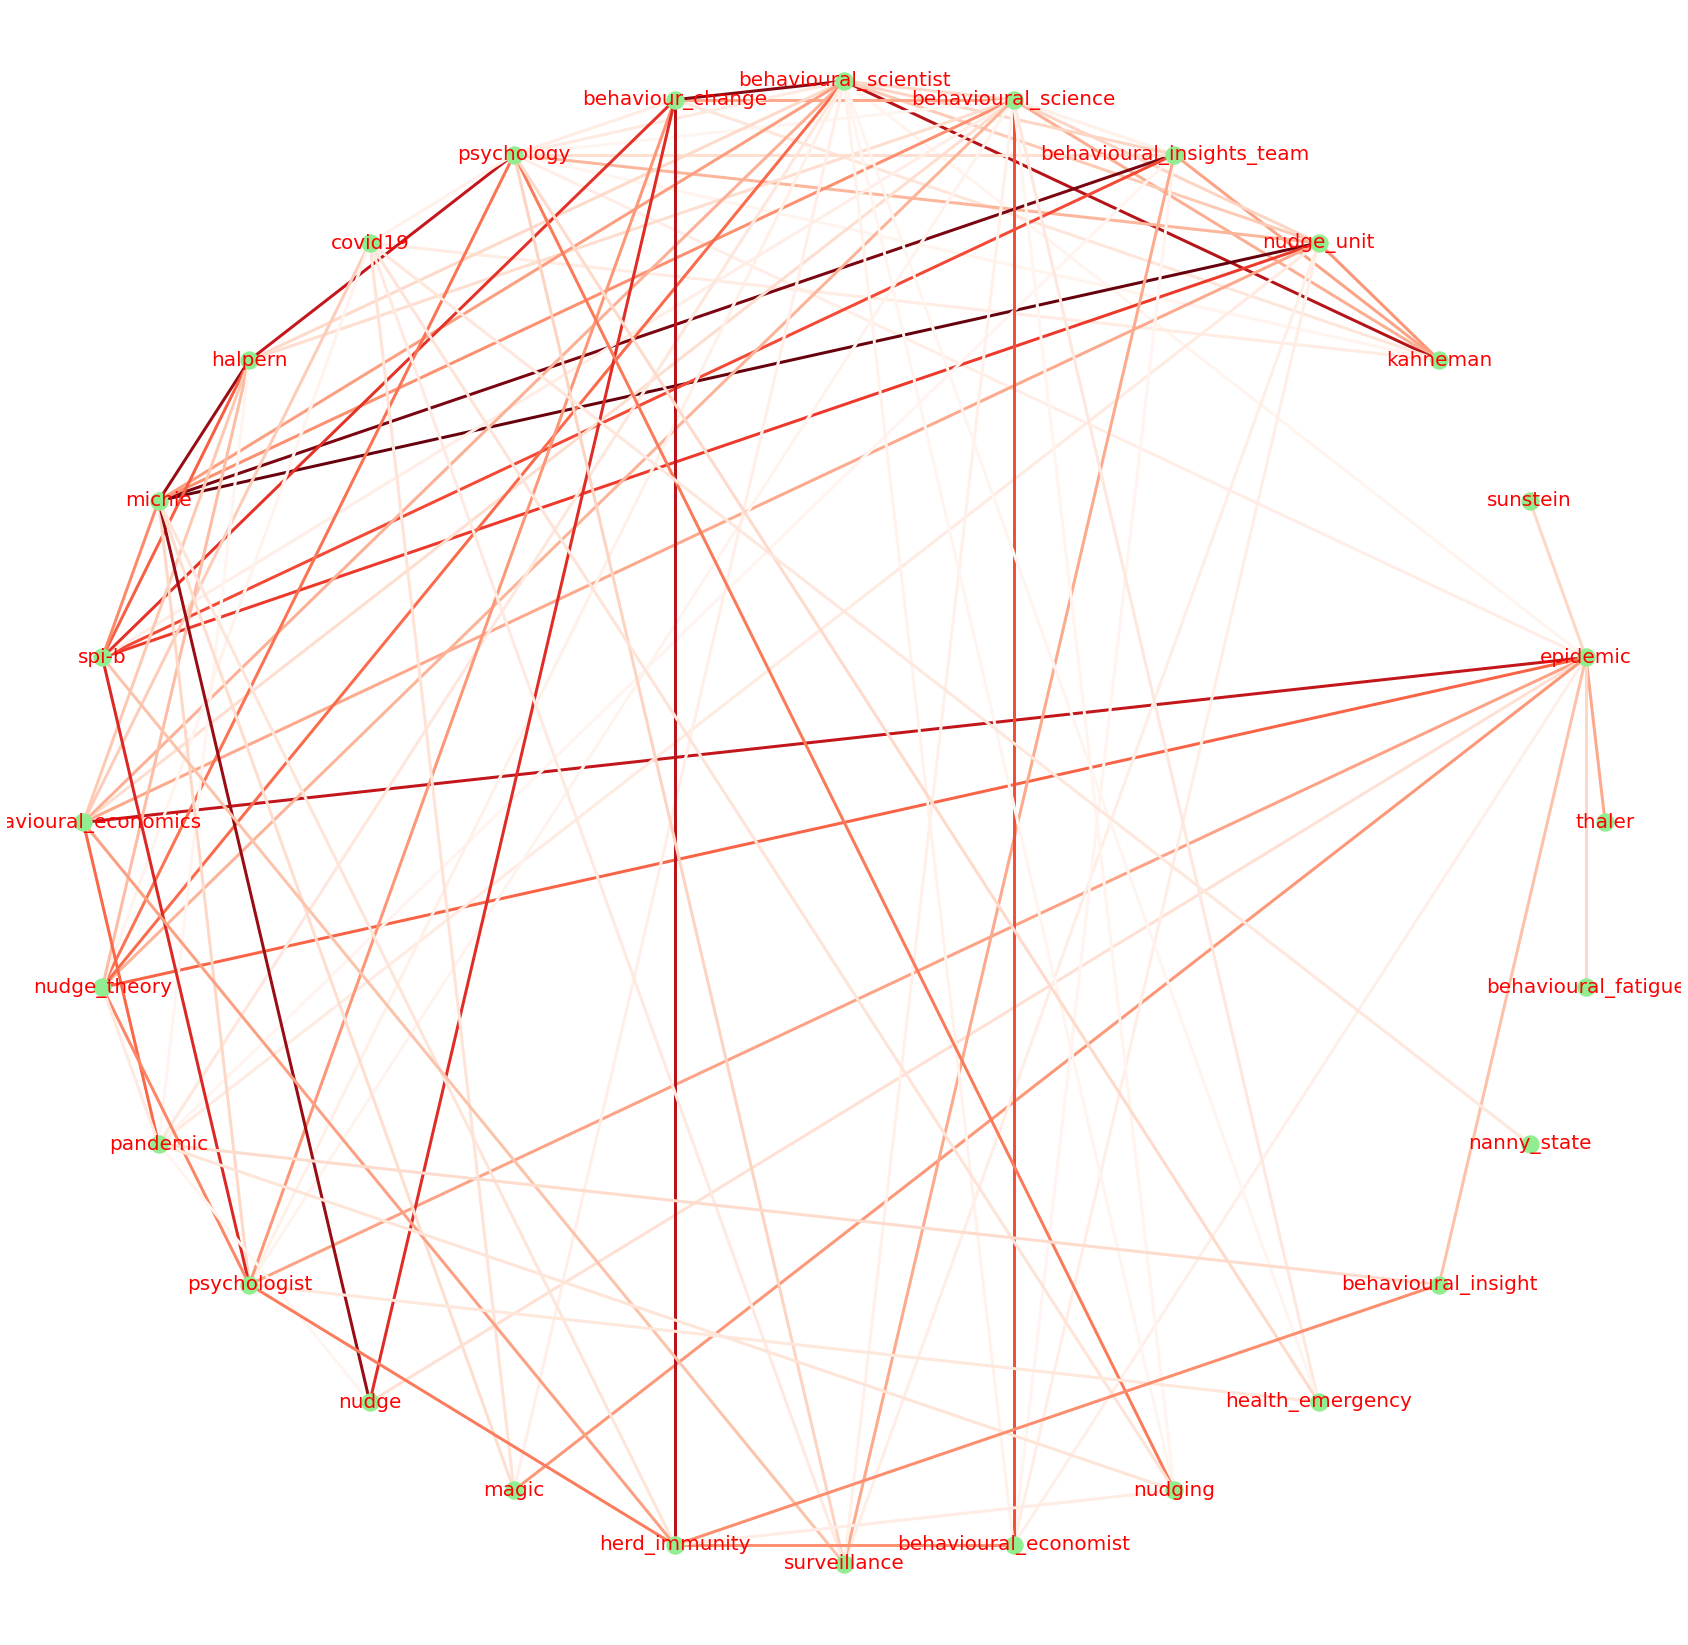

In [317]:
fig, ax = plt.subplots(figsize=(30,30))   
nx.draw_circular(doc_neg_pmi_kword_graph, 
                 with_labels=True, 
                 edge_color=doc_neg_pmi_weights,
                 width=3,
                 node_color='lightgreen',
                 font_size=20,
                 font_color='red',
                 font_weight=3,
                 edge_cmap=plt.cm.Reds
                )